In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.cluster import KMeans
import timm

from glob import glob
import json
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

### **Preprocess Data**

In [2]:
def generate_meta():
    json_files = glob("../dataset/Car/ds/ann/*.json")
    data = []
    max_boxes = 0
    
    for file in json_files:
        with open(file, 'r') as f:
                
            # Load the JSON data
            content = json.load(f)
            num_boxes = 0
            
            # Extract the relevant information from the JSON
            for obj in content['objects']:
                obj_id = obj['id']
                x_min = obj['points']['exterior'][0][0]
                y_min = obj['points']['exterior'][0][1]
                x_max = obj['points']['exterior'][1][0]
                y_max = obj['points']['exterior'][1][1]
                width = content['size']['width']
                height = content['size']['height']
                
                # Append the data to the list
                data.append({
                    'id': obj_id,
                    'name': os.path.basename(file)[:-5],
                    'class': 0,
                    'x_min': x_min,
                    'x_max': x_max,
                    'y_min': y_min,
                    'y_max': y_max,
                    'width': width,
                    'height': height
                })
                num_boxes += 1
        
        if num_boxes > max_boxes:
            max_boxes = num_boxes

    df = pd.DataFrame(data)
    return df, max_boxes

df, max_boxes = generate_meta()

In [3]:
def manage_padding(df):
    df['pad_left'] = 0
    df['pad_top'] = 0

    for index, row in df.iterrows():
        width = row['width']
        height = row['height']
        padding = abs(width - height)
        
        if (width > height):
            df.at[index, 'pad_top'] = padding // 2
            
        elif (width < height):
            df.at[index, 'pad_left'] = padding // 2
            
    return df

df = manage_padding(df)

In [ ]:
def padding_image(df):
    ds_dir = "../dataset/Car/ds/img/"
    for index, row in df.iterrows():
        image = Image.open(os.path.join(ds_dir, df.at[index, "name"]))
        max_dim = max(df.at[index, "width"], df.at[index, "height"])
        padded_image = Image.new('RGB', (max_dim, max_dim), (0, 0, 0))
        padded_image.paste(image, (df.at[index, 'pad_left'], df.at[index, 'pad_top']))
        
        df.at[index, 'x_min'] += df.at[index, 'pad_left']
        df.at[index, 'x_max'] += df.at[index, 'pad_left']
        df.at[index, 'y_min'] += df.at[index, 'pad_top']
        df.at[index, 'y_max'] += df.at[index, 'pad_top']
        
        df.at[index, 'x_min'] = df.at[index, 'x_min'] / max_dim
        df.at[index, 'x_max'] = df.at[index, 'x_max'] / max_dim
        df.at[index, 'y_min'] = df.at[index, 'y_min'] / max_dim
        df.at[index, 'y_max'] = df.at[index, 'y_max'] / max_dim
        
        padded_image.save(f"../dataset/Car/ds/new/{df.at[index, 'name']}.png")
        
    return df

df = padding_image(df)
df.to_csv("../dataset/Car/ds/meta.csv", index=False)

### **Data reader**

In [5]:
df = pd.read_csv("../dataset/Car/ds/meta.csv")

In [39]:
base = timm.create_model('xcit_tiny_24_p16_384.fb_dist_in1k', pretrained=True)
data_config = timm.data.resolve_model_data_config(base)
transforms = timm.data.create_transform(**data_config, is_training=False)
transforms

Compose(
    Resize(size=384, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(384, 384))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [40]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, ds_dir, transform):
        self.img_dir = os.path.join(ds_dir, 'new')
        self.img_paths = glob(os.path.join(self.img_dir, "*.png"))
        self.data_frame = pd.read_csv(os.path.join(ds_dir, 'meta.csv'))
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        x = self.transform(Image.open(self.img_paths[index]).convert("RGB").resize((384, 384)))
        name = os.path.basename(self.img_paths[index])
        target = self.data_frame.loc[
            self.data_frame['name'] == name, 
            ['class', 'x_min', 'x_max', 'y_min', 'y_max']
        ].values.tolist()
        
        target += [[0] * 5] * (6 - len(target))
        return x, torch.tensor(np.array(target)).to(torch.float32)
    
data_loader = torch.utils.data.DataLoader(
    CarDataset(
        ds_dir='../dataset/Car/ds/',
        transform=transforms
    ),
    batch_size=12, 
    shuffle=True
)

### **Utility**

In [7]:
def box_corner_to_center(boxes):
    """
    boxes: (num_boxes, x1, y1, x2, y2)
    where (x1,y1) is the upper corner left coordinate
    and   (x2, y2) is the bottom corner right coo
    """
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

def draw_bbox(image, coords):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    x_min, x_max, y_min, y_max = coords
    rect = plt.Rectangle((x_min * 256.0, y_min * 256.0), 
                         x_max * 256.0 - x_min * 256.0, 
                         y_max * 256.0 - y_min * 256.0, 
                         linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

### **Prepare anchor boxes**

#### **K-means**

In [9]:
df = pd.read_csv("../dataset/Car/ds/meta.csv")
df["width_box"] = df["x_max"] - df["x_min"]
df["height_box"] = df["y_max"] - df["y_min"]
df

,id,name,class,x_min,x_max,y_min,y_max,width,height,pad_left,pad_top,width_box,height_box
0,6325281,Cars0.png,0,0.452000,0.838000,0.482,0.5780,500,268,0,116,0.3860,0.0960
1,6325304,Cars1.png,0,0.335000,0.655000,0.510,0.5900,400,248,0,76,0.3200,0.0800
2,6325367,Cars10.png,0,0.350000,0.757500,0.230,0.5875,400,225,0,87,0.4075,0.3575
3,6325292,Cars100.png,0,0.437500,0.535000,0.450,0.4925,400,267,0,66,0.0975,0.0425
4,6325320,Cars101.png,0,0.417500,0.600000,0.630,0.6750,400,300,0,50,0.1825,0.0450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,6325238,Cars95.png,0,0.463333,0.678333,0.470,0.6050,600,400,0,100,0.2150,0.1350
429,6325206,Cars96.png,0,0.332500,0.652500,0.505,0.5900,400,248,0,76,0.3200,0.0850
430,6325194,Cars97.png,0,0.245000,0.742500,0.380,0.6025,400,300,0,50,0.4975,0.2225
431,6325459,Cars98.png,0,0.250000,0.655000,0.490,0.6475,370,400,15,0,0.4050,0.1575


In [10]:
X = df[['width_box', 'height_box']]
kmeans = KMeans(n_clusters=3, random_state=0)
df['anchor_box'] = kmeans.fit_predict(X)
anchor_sizes = kmeans.cluster_centers_
area = anchor_sizes[:,0] * anchor_sizes[:, 1]
area

array([0.00866212, 0.04040416, 0.19752403])

In [11]:
increments = np.arange(5).reshape(-1, 1) * 0.05
sizes = area + increments
print(sizes)

[[0.00866212 0.04040416 0.19752403]
 [0.05866212 0.09040416 0.24752403]
 [0.10866212 0.14040416 0.29752403]
 [0.15866212 0.19040416 0.34752403]
 [0.20866212 0.24040416 0.39752403]]


#### **Multiscale anchor boxes**

In [12]:
# We have 5 scales
depths = [192, 192, 192, 192, 192]
width =  [24, 12,   6,   3,   1]
height = [24, 12,   6,   3,   1]


X_multiscale = [
    torch.randn(1, depths[0], width[0], height[0]),
    torch.randn(1, depths[1], width[1], height[1]),
    torch.randn(1, depths[2], width[2], height[2]),
    torch.randn(1, depths[3], width[3], height[3]),
    torch.randn(1, depths[4], width[4], height[4]),
]

ratios = [[1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5],
          [1, 2, 0.5]]

num_anchors_per_pixel = len(sizes[0]) * len(ratios[0])
print(f"Each group (pixel) has {num_anchors_per_pixel} anchor boxes")

Each group (pixel) has 9 anchor boxes


In [13]:
class CreateAnchorBoxes:
    """
    Takes image scale size to generate coordinates of all anchor boxes given ratios and sizes.
    
    image: (batch_size, channel, width, height)
    sizes: 1D list
    ratios: 1D list
    """
    def __init__(self, image, sizes, ratios):
        self.image_height, self.image_width = image.shape[-2], image.shape[-1]
        self.sizes = torch.tensor(sizes, device='cuda')
        self.ratios = torch.tensor(ratios, device='cuda')
        self.num_boxes = len(sizes) * len(ratios)
        self.create_grid_center_points()
        self.create_anchor_width_height()

    def create_grid_center_points(self):
        self.center_x_axis = (torch.arange(self.image_width, device='cuda') + 0.5) / self.image_width
        self.center_y_axis = (torch.arange(self.image_height, device='cuda') + 0.5) / self.image_height
        self.grid_x_coords, self.grid_y_coords = torch.meshgrid(self.center_x_axis, self.center_y_axis)
        self.grid_x_coords = self.grid_x_coords.reshape(-1)
        self.grid_y_coords = self.grid_y_coords.reshape(-1)

    def create_anchor_width_height(self):
        width_anchor = torch.tensor([], device='cuda')
        height_anchor = torch.tensor([], device='cuda')

        for size in self.sizes:
            for ratio in self.ratios:
                width_anchor = torch.cat((width_anchor, size * torch.sqrt(ratio).unsqueeze(0)))
                height_anchor = torch.cat((height_anchor, size / torch.sqrt(ratio).unsqueeze(0)))

        self.grid_width_height = torch.stack(
            (-width_anchor, -height_anchor,
             width_anchor, height_anchor)
        ).T.repeat(self.image_height * self.image_width, 1) / 2

    def mapping(self):
        out_grid = torch.stack(
            [self.grid_x_coords, self.grid_y_coords,
             self.grid_x_coords, self.grid_y_coords],
            dim=1).repeat_interleave(self.num_boxes, dim=0)
        return out_grid + self.grid_width_height

In [15]:
def prepare_anchor_boxes(X_multiscale, sizes, ratios, num_anchors_per_pixel):
    
    anchors_multiscale = []

    for i in range(len(X_multiscale)):
        
        create_anchor_func = CreateAnchorBoxes(
            image=X_multiscale[i], 
            sizes=sizes[i], 
            ratios=ratios[i]
        )
        anchors = create_anchor_func.mapping()
        anchors_multiscale.append(anchors.unsqueeze(0))
        
        total_anchors = X_multiscale[i].shape[2] * X_multiscale[i].shape[3] * num_anchors_per_pixel
        print(f"Total anchor boxes are: {total_anchors} -> anchor shape: {anchors.shape}")
        
    anchors_multiscale = torch.cat(anchors_multiscale, dim=1)
    return anchors_multiscale
        
anchors_multiscale = prepare_anchor_boxes(X_multiscale, sizes, ratios, num_anchors_per_pixel)
print(anchors_multiscale.shape)

Total anchor boxes are: 5184 -> anchor shape: torch.Size([5184, 4])
Total anchor boxes are: 1296 -> anchor shape: torch.Size([1296, 4])
Total anchor boxes are: 324 -> anchor shape: torch.Size([324, 4])
Total anchor boxes are: 81 -> anchor shape: torch.Size([81, 4])
Total anchor boxes are: 9 -> anchor shape: torch.Size([9, 4])
torch.Size([1, 6894, 4])


### **Training**

#### **Network**

In [17]:
class Downsampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        return self.layers(x)
        
class BaseNet(nn.Module):
    def __init__(self, base_net):
        super().__init__()
        self.base_net = base_net
        
    def forward(self, x):
        x =  self.base_net.forward_intermediates(x, intermediates_only=True, indices=[23])[0]
        return x
    
class ScaleModule(nn.Module):
    def __init__(self, in_channel, out_channel, num_classes, num_anchors, baseNet=None, avg_pool=False):
        super().__init__()
        
        if baseNet is not None:
            self.downsample = baseNet
        elif avg_pool:
            self.downsample = nn.AdaptiveMaxPool2d((1,1))
        else:
            self.downsample = Downsampling(in_channel, out_channel)
            
        self.cls_head = nn.Conv2d(out_channel, num_anchors * (num_classes + 1), kernel_size=3, padding=1)
        self.bbox_head = nn.Conv2d(out_channel, num_anchors * 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.downsample(x)
        cls_pred = self.cls_head(x)
        bbox_pred = self.bbox_head(x)
        return x, cls_pred, bbox_pred
    

class SSD(nn.Module):
    def __init__(self, num_classes, num_anchors, base_net):
        super().__init__()
        self.num_classes = num_classes
        self.base_net = BaseNet(base_net)
        self.scale_module_1 = ScaleModule(3, 192, num_classes, num_anchors, baseNet=self.base_net)
        self.scale_module_2 = ScaleModule(192, 192, num_classes, num_anchors)
        self.scale_module_3 = ScaleModule(192, 192, num_classes, num_anchors)
        self.scale_module_4 = ScaleModule(192, 192, num_classes, num_anchors)
        self.scale_module_5 = ScaleModule(192, 192, num_classes, num_anchors, avg_pool=True)
        
    def flatten_pred(self, pred):
        return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
        
    def concat_preds(self, preds):
        return torch.cat([self.flatten_pred(pred) for pred in preds], dim=1)
        
    def post_process(self):
        self.cls_preds = self.concat_preds(self.cls_preds)
        self.cls_preds = self.cls_preds.reshape(self.cls_preds.shape[0], -1, self.num_classes + 1)
        self.bbox_preds = self.concat_preds(self.bbox_preds)
            
    def forward(self, x):
        
        self.cls_preds, self.bbox_preds = [], []
        
        x, cls_pred, bbox_pred = self.scale_module_1(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_2(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_3(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_4(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        x, cls_pred, bbox_pred = self.scale_module_5(x)
        self.cls_preds.append(cls_pred)
        self.bbox_preds.append(bbox_pred)
        
        self.post_process()
        
        return x, self.cls_preds, self.bbox_preds

In [18]:
X = torch.randn(1, 3, 384, 384).cuda()
model = SSD(num_classes=1, num_anchors=9, base_net=base).cuda()
x_, cls_preds, bbox_preds = model(X)
x_.shape, anchors_multiscale.shape, cls_preds.shape, bbox_preds.shape

(torch.Size([1, 192, 1, 1]),
 torch.Size([1, 6894, 4]),
 torch.Size([1, 6894, 2]),
 torch.Size([1, 27576]))

### **Training**

In [19]:
num_epochs = 20
model = SSD(num_classes=1, num_anchors=9, base_net=base).cuda()

cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    
    cls = cls_loss(
        cls_preds.reshape(-1, num_classes),
        cls_labels.reshape(-1)
    ).reshape(batch_size, -1).mean(dim=1)
    
    bbox = bbox_loss(
        bbox_preds * bbox_masks,
        bbox_labels * bbox_masks
    ).mean(dim=1)
    
    return cls + bbox

optimizer = torch.optim.SGD(model.parameters(), lr=0.2, weight_decay=5e-4)

class Accumulator:

    def __init__(self, n):
        """Defined in :numref:`sec_utils`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
metric = Accumulator(4)

def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    bbox_preds[torch.isnan(bbox_preds)] = 0
    bbox_labels[torch.isnan(bbox_labels)] = 0
    bbox_masks[torch.isnan(bbox_masks)] = 0
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [20]:
def calculate_box_area(boxes):
    return ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])).cuda()

def BoxIou(boxes1, boxes2):
    boxes1 = boxes1.cuda()
    boxes2 = boxes2.cuda()
    
    areas1 = calculate_box_area(boxes1)
    areas2 = calculate_box_area(boxes2)

    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)

    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas


def assign_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.5):
    
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    jaccard = BoxIou(anchors, ground_truth)

    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device="cuda")

    max_ious, indices = torch.max(jaccard, dim=1)
    if isinstance(iou_threshold, float):
        iou_threshold = torch.tensor(iou_threshold, device=max_ious.device)
        
    anc_i = torch.nonzero(max_ious >= iou_threshold, as_tuple=False).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j

    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
        
    return anchors_bbox_map

def offset_boxes(anchors, assigned_bb, eps=1e-6):
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [21]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    num_anchors = anchors.shape[0]
    
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors)    
        
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device="cuda")
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device="cuda")

        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]

        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]

        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [41]:
min_cls_err = 100000
min_bbox_mae = 100000 

for epoch in range(num_epochs):
    model.train()
    for X, Y in data_loader:
        optimizer.zero_grad()
        X = X.cuda()
        Y = Y.cuda()
        x_, cls_preds, bbox_preds = model(X)
        
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors_multiscale, Y)
        loss = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks).mean()
        loss.backward()
        optimizer.step()

        metric.add (
            cls_eval(cls_preds, cls_labels), 
            cls_labels.numel(),
            bbox_eval(bbox_preds, bbox_labels, bbox_masks),
            bbox_labels.numel()
        )
        
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    print(f"Epoch: {epoch+1} --- Class error: {cls_err} --- Box MAE: {bbox_mae}")
    
    if (cls_err < min_cls_err and bbox_mae < min_bbox_mae):
        min_loss = loss
        min_bbox_mae = bbox_mae
        torch.save(model.state_dict(), "../.cache/models/ssd_car.pt")

print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')

### **Non-max suppression**

In [27]:
def offset_inverse(anchors, offset_preds):
    
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

def nms(boxes, scores, iou_threshold):
    
    """Sort confidence scores of predicted bounding boxes."""
    
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = [] 
    
    while B.numel() > 0:
        i = B[0]
        keep.append(i)        
        if B.numel() == 1: 
            break

        iou = BoxIou(
            boxes[i, :].reshape(-1, 4),
            boxes[B[1:], :].reshape(-1, 4)
        ).reshape(-1)
        
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
        
    return torch.tensor(keep, device=boxes.device)

In [26]:
def multibox_detection(
    cls_probs, offset_preds, 
    anchors, nms_threshold=0.5,
    pos_threshold=0.009999999
):
    
    """Predict bounding boxes using non-maximum suppression."""
    
    batch_size = cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_anchors = cls_probs.shape[2]
    out = []
    
    for i in range(batch_size):
        
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        
        # Find all non-`keep` indices and set the class to background
        
        all_idx = torch.arange(num_anchors, dtype=torch.long, device="cuda")
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        
        pred_info = torch.cat((
            class_id.unsqueeze(1),
            conf.unsqueeze(1),
            predicted_bb), dim=1)
        
        out.append(pred_info)
        
    return torch.stack(out)

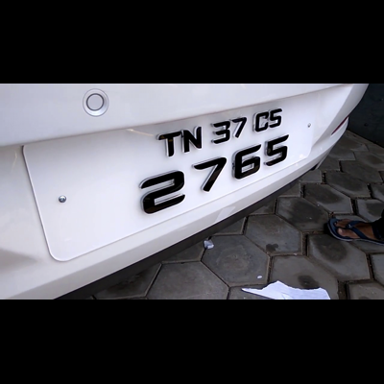

In [23]:
img = Image.open("../dataset/Car/ds/new/Cars10.png").convert("RGB").resize((384, 384))
img

In [24]:
image = np.array(img)
x = transforms(img).unsqueeze(0)

In [28]:
def predict(X):
    model.eval()
    x_, cls_preds, bbox_preds = model(X.cuda())
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors_multiscale.cuda())
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

In [29]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""

    return plt.Rectangle (
        xy=(bbox[0], bbox[1]), 
        width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2
    )

In [30]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['r', 'r', 'r', 'r', 'r'])
    
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(
                rect.xy[0], rect.xy[1], labels[i],
                va='center', ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0)
            )

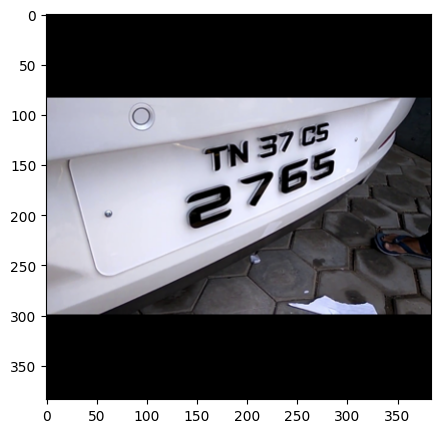

In [37]:
def display(img, output, threshold):
    plt.figure(figsize=(5, 5))
    fig = plt.imshow(img)
    
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2] * 384
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(image, output.cpu(), threshold=0.9)